<div style="text-align:center;"><h1>LSTM PyTorch</h1></div>




In [847]:
"""
The idea comes from this scratch version of LSTM:
https://www.kaggle.com/rayjan/lstm-neural-network-from-scratch-106ffb/edit
The main goal of this subject is to learn the concept of LSTM with PyTorch that you can also
compare with the scratch version on Kaggle link above.
This toy code doesn't carefully setted up with exception, it can cause error if you change some
hyperparameters such as BATCH_SIZE...
"""
import os
import numpy as np  
import pandas as pd 
import torch
import torch.utils.data as torch_data
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.utils.data as Data
from torch import optim
# from google.colab import drive
# drive.mount('/content/drive')
# path = F'/content/drive/My Drive/ColabNotebooks/'
model_save_name = 'checkpoint/LSTM.pt'
# init_para = torch.load(path + model_save_name)

In [0]:
#data 
data = pd.read_csv(path+'data/NationalNames.csv')
print(data.loc[0:3,:])
#get names from the dataset
data['Name'] = data['Name']
print(data.shape)
#get last 128000 names
name_num = 128000
data = np.array(data['Name'][data.shape[0]-name_num:data.shape[0]]).reshape(-1,1)
# data = np.array(data['Name'][300000:(300000+name_num)]).reshape(-1,1)

#covert the names to lowee case
data = [x.lower() for x in data[:,0]]

data = np.array(data).reshape(-1,1)

   Id       Name  Year Gender  Count
0   1       Mary  1880      F   7065
1   2       Anna  1880      F   2604
2   3       Emma  1880      F   2003
3   4  Elizabeth  1880      F   1939
(1825433, 5)


In [0]:
print("Data Shape = {}".format(data.shape))
print(data.shape)
print("Lets see some names : ")
print(data[:10])

Data Shape = (128000, 1)
(128000, 1)
Lets see some names : 
[['inessa']
 ['isyss']
 ['jacob']
 ['jaelynne']
 ['janaye']
 ['janiece']
 ['janis']
 ['jasmina']
 ['jazalynn']
 ['jazell']]


In [0]:
#to store the transform data
transform_data = np.copy(data)

#find the max length name
max_length = 0
for index in range(len(data)):
    max_length = max(max_length,len(data[index,0]))

#make every name of max length by adding '.'
for index in range(len(data)):
    length = (max_length - len(data[index,0]))
    string = '.'*length
    transform_data[index,0] = ''.join([transform_data[index,0],string])
print(max_length)

15


In [0]:
print("Transformed Data")
print(transform_data[1:10])

Transformed Data
[['isyss..........']
 ['jacob..........']
 ['jaelynne.......']
 ['janaye.........']
 ['janiece........']
 ['janis..........']
 ['jasmina........']
 ['jazalynn.......']
 ['jazell.........']]


In [0]:
#to store the vocabulary
vocab = list()
for name in transform_data[:,0]:
    vocab.extend(list(name))

vocab = set(vocab)
vocab_size = len(vocab)

print("Vocab size = {}".format(len(vocab)))
print("Vocab      = {}".format(vocab))

Vocab size = 27
Vocab      = {'p', 'u', 'a', 'e', 's', 'm', 'c', 'f', 'j', 'q', 'z', 'i', 'y', 'x', 't', 'w', 'd', 'h', 'n', 'g', 'b', 'r', 'l', '.', 'v', 'o', 'k'}


In [0]:
#map char to id and id to chars
char_id = dict()
id_char = dict()

for i,char in enumerate(vocab):
    char_id[char] = i
    id_char[i] = char


print('a-{}, 19-{}'.format(char_id['a'],id_char[19]))


a-2, 19-g


In [0]:
number_data = np.array([[char_id[ch] for ch in name[0]] for name in transform_data])
print(number_data[:10])

[[11 18  3  4  4  2 23 23 23 23 23 23 23 23 23]
 [11  4 12  4  4 23 23 23 23 23 23 23 23 23 23]
 [ 8  2  6 25 20 23 23 23 23 23 23 23 23 23 23]
 [ 8  2  3 22 12 18 18  3 23 23 23 23 23 23 23]
 [ 8  2 18  2 12  3 23 23 23 23 23 23 23 23 23]
 [ 8  2 18 11  3  6  3 23 23 23 23 23 23 23 23]
 [ 8  2 18 11  4 23 23 23 23 23 23 23 23 23 23]
 [ 8  2  4  5 11 18  2 23 23 23 23 23 23 23 23]
 [ 8  2 10  2 22 12 18 18 23 23 23 23 23 23 23]
 [ 8  2 10  3 22 22 23 23 23 23 23 23 23 23 23]]


In [0]:
def one_hot_encode(arr, n_labels):
    
    # Initialize the the encoded array
    one_hot = np.zeros((np.multiply(*arr.shape), n_labels), dtype=np.float32)
    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    
    return one_hot

onehot_data = torch.from_numpy(one_hot_encode(number_data, len(vocab)))
onehot_data[0,:]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1

In [0]:
BATCH_SIZE = 128

In [0]:
def make_loader(one_hot_data, batch_size = BATCH_SIZE):
    one_hot_data = one_hot_data.view(-1, BATCH_SIZE, max_length, vocab_size)
    one_hot_data = one_hot_data.permute(0,2,1,3)
    x_onehot = one_hot_data[:,:(max_length-1),:,:]
    y_onehot = one_hot_data[:,1:,:,:]
    for i in range(one_hot_data.shape[0]):
        yield x_onehot[i], y_onehot[i]  
        
batch_test = next(make_loader(onehot_data))
print(batch_test[0].shape)
print(torch.max(batch_test[0],2)[1])
print(torch.max(batch_test[1],2)[1])
print(batch_test[0][0])


torch.Size([14, 128, 27])
tensor([[11, 11,  8,  ...,  2,  2,  2],
        [18,  4,  2,  ..., 11, 11, 26],
        [ 3, 12,  6,  ..., 21, 12, 11],
        ...,
        [23, 23, 23,  ..., 23, 23, 23],
        [23, 23, 23,  ..., 23, 23, 23],
        [23, 23, 23,  ..., 23, 23, 23]])
tensor([[18,  4,  2,  ..., 11, 11, 26],
        [ 3, 12,  6,  ..., 21, 12, 11],
        [ 4,  4, 25,  ...,  2,  2, 21],
        ...,
        [23, 23, 23,  ..., 23, 23, 23],
        [23, 23, 23,  ..., 23, 23, 23],
        [23, 23, 23,  ..., 23, 23, 23]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])


In [0]:
HIDDEN_DIM = 256
EPOCH = 100
CLIP = 5
LR = 0.0003
NUM_LAYERS = 2

In [0]:
class lstm(nn.Module):
    def __init__(self,  vocab_size, hidden_dim, num_layers = NUM_LAYERS):
        super(lstm, self).__init__()
        self.word_embeddings = nn.Linear(vocab_size, vocab_size*5)
        self.lstm = nn.LSTM(vocab_size*5, hidden_dim ,num_layers = num_layers, batch_first=False)
        self.hidden2vocab = nn.Linear(hidden_dim, vocab_size)
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(0.5)

    def forward(self, x_onehot, hc):
        embeds = self.word_embeddings(x_onehot)
        lstm_out, (h,c) = self.lstm(embeds, hc)
        lstm_out = lstm_out.contiguous().view(lstm_out.size()[0]*lstm_out.size()[1], self.hidden_dim)
        lstm_out = self.dropout(lstm_out)
        vocab_space = self.hidden2vocab(lstm_out)
        return vocab_space, (h,c)
      
    def init_hidden(self, batch_size = BATCH_SIZE):
        ''' Initializes hidden state '''
        weight = next(self.parameters()).data
        return (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                weight.new(self.n_layers, batch_size, self.n_hidden).zero_())

torch.Size([1792, 27])
torch.Size([2, 128, 256])
torch.Size([2, 128, 256])
epoch:  0
599.0479695796967
epoch:  10
593.4541606903076


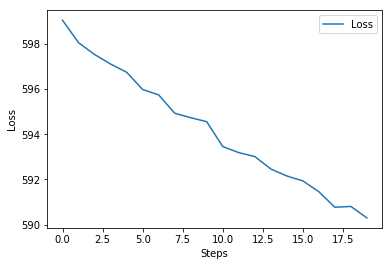

In [0]:
model = lstm(len(vocab), HIDDEN_DIM).cuda()
if init_para is not None:
    model.load_state_dict(init_para)
model.train()
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=LR)
# Here we don't need to train, so the code is wrapped in torch.no_grad()
hc = (torch.zeros((NUM_LAYERS,BATCH_SIZE,HIDDEN_DIM)).cuda(),torch.zeros((NUM_LAYERS,BATCH_SIZE,HIDDEN_DIM)).cuda())
with torch.no_grad():
    x_test = next(make_loader(onehot_data))[0].cuda()
    test_scores ,(h,c) = model(x_test,hc)
    print(test_scores.shape)
    print(h.shape)
    print(c.shape)

running_loss = np.zeros((EPOCH,))
for epoch in range(EPOCH): 
    hc = (torch.zeros((NUM_LAYERS,BATCH_SIZE,HIDDEN_DIM)).cuda(),torch.zeros((NUM_LAYERS,BATCH_SIZE,HIDDEN_DIM)).cuda())
    for step, (x_b, y_b) in enumerate(make_loader(onehot_data)):  
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()
        hc = tuple([each.data for each in hc])
        
        # Step 2. Run our forward pass.
        x_b = x_b.cuda()
        name_scores, hc = model(x_b, hc)

        target = torch.max(y_b,2)[1].flatten().cuda()
        # Step 3. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = criterion(name_scores,target)
        running_loss[epoch] += loss.item()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        opt.step()
    if epoch % 10 == 0:
        print('epoch: ' , epoch)
        print(running_loss[epoch])
        torch.save(model.state_dict(), path + model_save_name)
            
plt.plot(running_loss, label='Loss')
plt.legend(loc='best')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show() 
#the loss pic below may not be a perfect L shape, 
#It's because I loaded and trained the parameters multiple times.




In [0]:
torch.save(model.state_dict(), path + model_save_name)
init_para = torch.load(path + model_save_name)


In [0]:
import random
def make_new_name(model, first_letter = 'R'):
    new_name_ls = [first_letter]
    first_letter = first_letter.lower()
    first_letter_id = np.array([[char_id[first_letter]]])
    first_onehot = one_hot_encode(first_letter_id, len(vocab))
    first_onehot = torch.from_numpy(first_onehot)
    model.eval()
    model.cpu()
    
    hc = (torch.zeros((NUM_LAYERS,1,HIDDEN_DIM)),torch.zeros((NUM_LAYERS,1,HIDDEN_DIM)))
    pred, hc = model(first_onehot,hc)
    pred_num = torch.max(pred,1)[1].item()
    while pred_num != char_id['.']:
        new_name_ls.append(id_char[pred_num])
        new_letter_id = np.array([[pred_num]])
        new_letter_onehot = torch.from_numpy(one_hot_encode(new_letter_id, len(vocab)))
        pred, hc = model(new_letter_onehot,hc)
        pred_num = torch.max(pred,1)[1].item()
        
    
    return "".join(new_name_ls)
 
for s in vocab:
    s = s.upper()
    print(make_new_name(model,s))

Patrick
Ura
Alexandria
Elianna
Shantell
Marianna
Carlee
Fathima
Jayden
Quinnlyn
Zana
Isaly
Yanni
Xander
Taylor
Waldo
Danielle
Harley
Nashay
Gracelyn
Britta
Roselynn
Laniyah
.
Vianna
Oluwadamilola
Kaylen
